In [2]:
from simple_multi_unet_model import * # Uses softmax as last activation
from supporters import *
from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import SimpleITK as sitk
import imageio
import nibabel as nib
import cv2

### Read train and mask files into numpy array

In [3]:
def read_volumetric_data():
    train_path = '../data/MM_WHS/train_images'
    mask_path = '../data/MM_WHS/mask_images'
    
    train_files = glob.glob(os.path.join(train_path, '*.nii.gz'))
    mask_files = glob.glob(os.path.join(mask_path, '*.nii.gz'))

    train_images = []
    for index_file in range(3):
        pat = sitk.ReadImage(train_files[index_file], sitk.sitkFloat32)
        pat = sitk.GetArrayFromImage(pat)
        for i in range(pat.shape[0]):
            train_images.append(pat[i])
            
    mask_images = []
    for index_file in range(3):
        pat = sitk.ReadImage(mask_files[index_file], sitk.sitkFloat32)
        pat = sitk.GetArrayFromImage(pat)
        for i in range(pat.shape[0]):
            mask_images.append(pat[i])
        
    train_images = np.array(train_images)
    mask_images = np.array(mask_images)
    return train_images, mask_images


train_images, mask_images = read_volumetric_data()
train_images.shape, mask_images.shape

((900, 512, 512), (900, 512, 512))

### Convert Nifti to Folder pngs

In [36]:
# Load the .nii.gz file
image = sitk.ReadImage("../data/MM_WHS/ct_train/ct_train_1001_image.nii.gz")
pat1001 = sitk.GetArrayFromImage(image)

def convert_nii_to_image():
    (z, x, y) = pat1001.shape 
    
    for i in range(z): 
        img = pat1001[i,:,:]
        img = (img - np.min(img)) / np.ptp(img)  # Normalize the data to 0 - 1
        img = 255 * img  # Now scale by 255
        img = img.astype(np.uint8)
        imageio.imsave(f'../data/MM_WHS/ct_train/ct_train_1001_image/{str(i).zfill(3)}.png', img)
        
convert_nii_to_image()

# Specify the path
path = '../data/MM_WHS/ct_train/ct_train_1001_image'

# Use glob to match the pattern '*.png', and sort the files
files = sorted(glob.glob(os.path.join(path, '*.png')))

train_images = []
for file in files:
    img = cv2.imread(file, 0)   
    train_images.append(img)   
    
train_images = np.array(train_images)

In [ ]:
explore_3D_array_comparison(train_images, pat1001)

### Encoding

In [64]:
# 8 pixel values -> background + 7 classes
y_res = np.unique(mask_images)
y_res

array([  0., 205., 420., 500., 550., 600., 820., 850.], dtype=float32)

In [4]:
# Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
n, h, w = mask_images.shape
mask_images_reshaped = mask_images.reshape(-1,1)

mask_images_reshaped_encoded = labelencoder.fit_transform(mask_images_reshaped)
mask_images_encoded_original_shape = mask_images_reshaped_encoded.reshape(n, h, w)
np.unique(mask_images_encoded_original_shape)

d:\Documents\GitHub\VascuIAR\.venv\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64)

In [5]:
train_images = np.expand_dims(train_images, axis=3)
train_images = normalize(train_images, axis=1)
train_masks_inputs = np.expand_dims(mask_images_encoded_original_shape, axis=3)

train_images.shape, train_masks_inputs.shape

((900, 512, 512, 1), (900, 512, 512, 1))

In [10]:
# after normalization
np.max(train_images), np.min(train_images), np.max(train_masks_inputs), np.min(train_masks_inputs)

(0.38129026, -0.37567228, 7, 0)

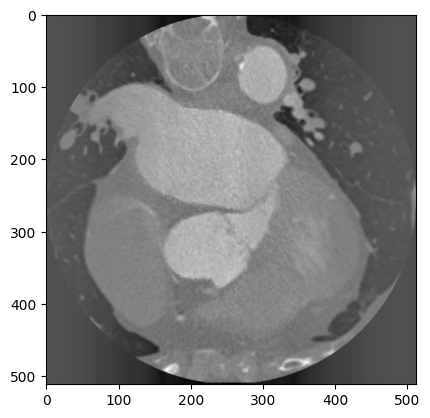

In [16]:
# image after normalization
plt.imshow(train_images[200], cmap="gray")

### Splitting data

In [6]:
n_classes = 8
'''
Create a subset of data for quick testing
Picking 10% for testing and remaining for training (train set + validation set)
'''

from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_inputs, test_size = 0.1, random_state = 0)

# Further split training data to a smaller subset for quick testing of models
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.2, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 

Class values in the dataset are ...  [0 1 2 3 4 5 6 7]


In [20]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(np.max(X_train), np.min(X_train), np.max(y_train), np.min(y_train))

(648, 512, 512, 1) (90, 512, 512, 1) (648, 512, 512, 1) (90, 512, 512, 1)
0.38129026 -0.37567228 7 0


In [7]:
n_classes = 8
from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [19]:
y_train_cat.shape, y_test_cat.shape

((648, 512, 512, 8), (90, 512, 512, 8))

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(mask_images_reshaped_encoded),
                                                 mask_images_reshaped_encoded)
print("Class weights are...:", class_weights)

### UNet truyền thống bình thường

In [23]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

# can replace with focal loss
model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 512, 512, 1)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 512, 512, 16)         160       ['input_2[0][0]']             
                                                                                                  
 dropout_9 (Dropout)         (None, 512, 512, 16)         0         ['conv2d_19[0][0]']           
                                                                                                  
 conv2d_20 (Conv2D)          (None, 512, 512, 16)         2320      ['dropout_9[0][0]']           
                                                                                            

In [24]:
history = model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=5, 
                    validation_data=(X_test, y_test_cat), 
                    # class_weight=class_weights,   
                    shuffle=False)

Epoch 1/5
41/41 [==============================] - 426s 10s/step - loss: 0.7291 - accuracy: 0.8106 - val_loss: 0.3569 - val_accuracy: 0.8923
Epoch 2/5
41/41 [==============================] - 397s 10s/step - loss: 0.3661 - accuracy: 0.8800 - val_loss: 0.3495 - val_accuracy: 0.8923
Epoch 3/5
41/41 [==============================] - 403s 10s/step - loss: 0.3175 - accuracy: 0.8843 - val_loss: 0.3350 - val_accuracy: 0.8976
Epoch 4/5
41/41 [==============================] - 405s 10s/step - loss: 0.2855 - accuracy: 0.8940 - val_loss: 0.2742 - val_accuracy: 0.8978
Epoch 5/5
41/41 [==============================] - 398s 10s/step - loss: 0.2547 - accuracy: 0.8954 - val_loss: 0.2489 - val_accuracy: 0.9037


In [32]:
history2 = model.fit(X_train, y_train_cat, batch_size = 16, initial_epoch=5, validation_data=(X_test, y_test_cat), verbose=1, epochs=10, shuffle=False)

Epoch 6/10
41/41 [==============================] - 511s 12s/step - loss: 0.2237 - accuracy: 0.9121 - val_loss: 0.1996 - val_accuracy: 0.9222
Epoch 7/10
22/41 [===============>..............] - ETA: 2:21 - loss: 0.1826 - accuracy: 0.9288

In [25]:
# save the model
model.save('training/models/model_multi_v1.hdf5')

# Evaluate the model
_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")

d:\Documents\GitHub\VascuIAR\.venv\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 13s 4s/step - loss: 0.2489 - accuracy: 0.9037
Accuracy is =  90.366530418396 %


In [ ]:
model.save('training/models/model_multi_v1.h5')

In [9]:
import tensorflow as tf
loaded_model = tf.keras.models.load_model('training/models/model_multi_v1.h5')

_, acc = loaded_model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")

3/3 [==============================] - 8s 2s/step - loss: 0.2489 - accuracy: 0.9037
Accuracy is =  90.366530418396 %


### Unet kết hợp VGG. Resnet làm BackBones

In [ ]:
import segmentation_models as sm

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
x_train = preprocess_input(X_train)
x_test = preprocess_input(X_test)

# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score],
)

model.fit(
   x=x_train,
   y=y_train,
   batch_size=16,
   epochs=100,
   validation_data=(x_test, y_test),
)

### Metrics Visualization

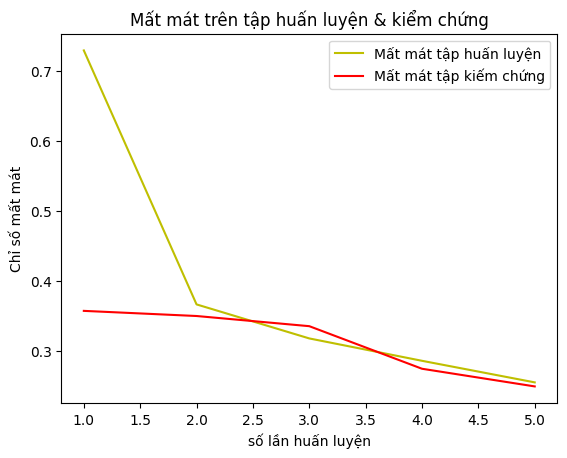

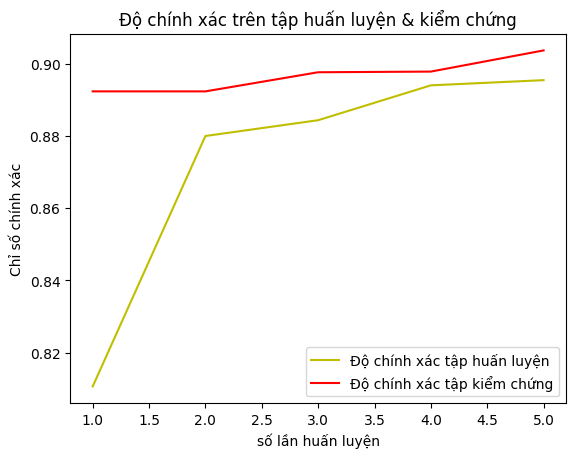

In [31]:
# Visualize metrics
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Mất mát tập huấn luyện')
plt.plot(epochs, val_loss, 'r', label='Mất mát tập kiếm chứng')
plt.title('Mất mát trên tập huấn luyện & kiểm chứng')
plt.xlabel('số lần huấn luyện')
plt.ylabel('Chỉ số mất mát')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Độ chính xác tập huấn luyện')
plt.plot(epochs, val_acc, 'r', label='Độ chính xác tập kiểm chứng')
plt.title('Độ chính xác trên tập huấn luyện & kiểm chứng')
plt.xlabel('số lần huấn luyện')
plt.ylabel('Chỉ số chính xác')
plt.legend()
plt.show()

### Intersection over Union

In [77]:
# Load sample and see what output is
sample = sitk.ReadImage('../data/MM_WHS/train_images/ct_train_1006_image.nii.gz', sitk.sitkFloat32)
sample = sitk.GetArrayFromImage(sample)
sample.shape

(248, 512, 512)

In [78]:
sample = np.expand_dims(sample, axis=3)
sample = normalize(sample, axis=1)
sample.shape

(248, 512, 512, 1)

In [79]:
y_pred = loaded_model.predict(sample)
y_pred

8/8 [==============================] - 17s 2s/step


array([[[[8.84443164e-01, 6.45455047e-02, 3.19357612e-03, ...,
          8.57966486e-03, 4.51195659e-03, 1.11510511e-02],
         [9.92509186e-01, 2.67760199e-03, 2.18142319e-04, ...,
          1.87961059e-03, 2.23476891e-04, 2.85389222e-04],
         [9.87628222e-01, 1.32743269e-03, 1.37299954e-04, ...,
          5.01189101e-03, 2.47798598e-04, 3.86315980e-04],
         ...,
         [9.69644189e-01, 2.89817038e-03, 4.59886127e-04, ...,
          1.85951460e-02, 8.10673810e-04, 6.82756712e-04],
         [9.21294332e-01, 7.51339598e-03, 3.47516313e-03, ...,
          3.56537588e-02, 5.12536941e-03, 3.22631048e-03],
         [4.86372471e-01, 6.84602708e-02, 2.11765375e-02, ...,
          1.74744278e-01, 3.16084549e-02, 3.27931643e-02]],

        [[9.17764425e-01, 2.66253818e-02, 8.56620725e-04, ...,
          1.07975118e-02, 1.13113946e-03, 1.38136325e-02],
         [9.97108042e-01, 1.59077765e-03, 2.33077526e-06, ...,
          1.81198571e-04, 1.23708005e-05, 2.05862321e-04],
        

In [95]:
y_pred.shape

(248, 512, 512, 8)

In [97]:
y_pred_argmax = np.argmax(y_pred, axis=3)
y_pred_argmax.shape

(248, 512, 512)

In [84]:
np.max(y_pred_argmax), np.min(y_pred_argmax)

(6, 0)

In [83]:
y_res

array([  0., 205., 420., 500., 550., 600., 820., 850.], dtype=float32)

In [90]:
y_res2 = np.array([ 205., 420., 500., 550., 600., 820., 850.])
y_res2

array([205., 420., 500., 550., 600., 820., 850.])

In [91]:
# use np.take to map the indices to values
y_mapped = np.take(y_res2, y_pred_argmax)

print(y_mapped.shape)
np.max(y_mapped), np.min(y_mapped)

(248, 512, 512)


(850.0, 205.0)

In [ ]:
explore_3D_array(y_mapped)

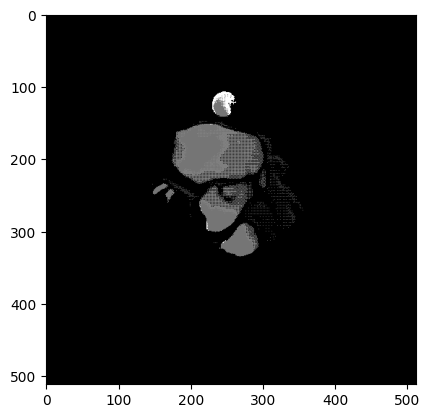

In [94]:
plt.imshow(y_mapped[135], cmap='gray')

In [ ]:
model.load_weights('training/models/model_multi_v1.hdf5')  

# IOU (Intersection over UNion)
y_pred = model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=3)

# Using built in keras function
from keras.metrics import MeanIoU
n_classes = 8
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

# To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)

class1_IoU = values[0,0] / (values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1] / (values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2] / (values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3] / (values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])
class5_IoU = values[3,3] / (values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])
class6_IoU = values[3,3] / (values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])
class7_IoU = values[3,3] / (values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])
class8_IoU = values[3,3] / (values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)
print("IoU for class4 is: ", class5_IoU)
print("IoU for class4 is: ", class6_IoU)
print("IoU for class4 is: ", class7_IoU)
print("IoU for class4 is: ", class8_IoU)


plt.imshow(train_images[0, :,:,0], cmap='gray')
plt.imshow(mask_images[0], cmap='gray')

1/1 [==============================] - 0s 114ms/step


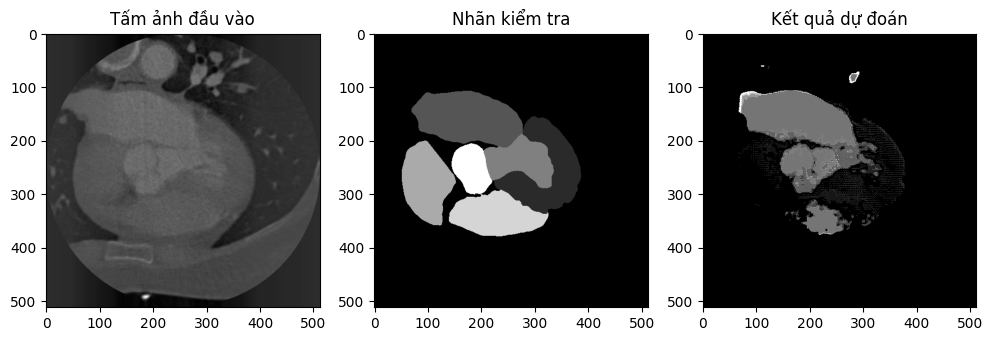

In [104]:
import random

test_img_number = random.randint(0, len(X_test))

test_img = X_test[test_img_number]
ground_truth = y_test[test_img_number]

test_img_norm = test_img[:,:,0][:,:,None]
test_img_input = np.expand_dims(test_img_norm, 0)

prediction = (model.predict(test_img_input))
predicted_img = np.argmax(prediction, axis=3)[0,:,:]
y_mapped = np.take(y_res2, predicted_img)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Tấm ảnh đầu vào')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Nhãn kiểm tra')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Kết quả dự đoán')
plt.imshow(y_mapped, cmap='gray')
plt.show()

In [ ]:
import random

test_img_number = random.randint(0, len(X_test))

test_img = X_test[test_img_number]
ground_truth = y_test[test_img_number]

test_img_norm = test_img[:,:,0][:,:,None]
test_img_input = np.expand_dims(test_img_norm, 0)

prediction = (model.predict(test_img_input))
predicted_img = np.argmax(prediction, axis=3)


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Tấm ảnh đầu vào')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Nhãn kiểm tra')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Kết quả dự đoán')
plt.imshow(predicted_img, cmap='gray')
plt.show()

In [ ]:
# Apply a trained model on large image
from patchify import patchify, unpatchify

large_image = cv2.imread('large_images/large_image.tif', 0)
# This will split the image into small images of shape [3,3]
patches = patchify(large_image, (128, 128), step=128)  # Step=256 for 256 patches means no overlap

predicted_patches = []
for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        print(i,j)
        
        single_patch = patches[i,j,:,:]       
        single_patch_norm = np.expand_dims(normalize(np.array(single_patch), axis=1),2)
        single_patch_input = np.expand_dims(single_patch_norm, 0)
        single_patch_prediction = (model.predict(single_patch_input))
        single_patch_predicted_img = np.argmax(single_patch_prediction, axis=3)[0,:,:]

        predicted_patches.append(single_patch_predicted_img)

predicted_patches = np.array(predicted_patches)
predicted_patches_reshaped = np.reshape(predicted_patches, (patches.shape[0], patches.shape[1], 128,128) )

reconstructed_image = unpatchify(predicted_patches_reshaped, large_image.shape)
plt.imshow(reconstructed_image, cmap='gray')
plt.imsave('imgs/seg.jpg', reconstructed_image, cmap='gray')

# Threshold everything above 0
# final_prediction = (reconstructed_image > 0.01).astype(np.uint8)
# plt.imshow(final_prediction)

In [ ]:
plt.hist(reconstructed_image.flatten())
plt.show()

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(221)
plt.title('Large Image')
plt.imshow(large_image, cmap='gray')
plt.subplot(222)
plt.title('Prediction of large Image')
plt.imshow(reconstructed_image, cmap='jet')
plt.show()